<a href="https://colab.research.google.com/github/Gops03/TEORIA_DE_SE-ALES/blob/main/radioian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dudas

- Cómo calcular el sdr para una señal.
-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def audio_matrix(path, scaler):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)


        y, sr = librosa.load(file_path, sr=None)
        y = librosa.to_mono(y)
        y = y.reshape(-1, 1)
        y = scaler.fit_transform(y)
        y = y.flatten()

        fs_v.append(sr)
        audio_m.append(y)

    # Calcular la frecuencia de muestreo promedio
    fs = np.mean(fs_v)

    # Asegurarse de que todos los arreglos de audio tengan la misma longitud
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m,  fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    psd_matrix = np.zeros((M,N))
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs,  window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif,  audio_m):
    N = audio_m.shape[1]

    one_count = np.sum(classif)
    zero_count = len(classif) - one_count

    audio_one_m = np.zeros((one_count, N))
    audio_zero_m = np.zeros((zero_count, N))

    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]

    return  audio_one_m, audio_zero_m

def firwin_filter(signal, lowcut, highcut, numtaps, fs): #Filtro FIR

    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)

    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    filtered_signal_m = np.zeros((M,N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

def snr(audio_ones, audio_zeros):
    signal = np.mean(audio_ones, axis=0)
    noise = np.mean(audio_zeros, axis=0)
    P_signal = np.mean(signal**2)
    P_noise = np.mean(noise**2)
    return 10 * np.log10(P_signal / P_noise)

In [ ]:
path = r'/content/drive/My Drive/TDS/ANEaudios'
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_m, fs = audio_matrix(path, scaler)

df = pd.read_excel('/content/drive/My Drive/TDS/Audios.xlsx')

df.head()

,Nombre,presencia,Columna1,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,88.0_0_.wav,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88.0_1_.wav,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88.0_2_.wav,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88.0_3_.wav,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88.0_4_.wav,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
lowcut = 30
highcut = 15000
numtaps = 301
audio_filt = audio_filter(audio_m, lowcut, highcut, numtaps, fs)

t = np.linspace(0, audio_filt.shape[1]/fs, num=audio_filt.shape[1])

classif = df['presencia '].to_numpy()

audio_ones, audio_zeros = audio_classif(classif, audio_filt)

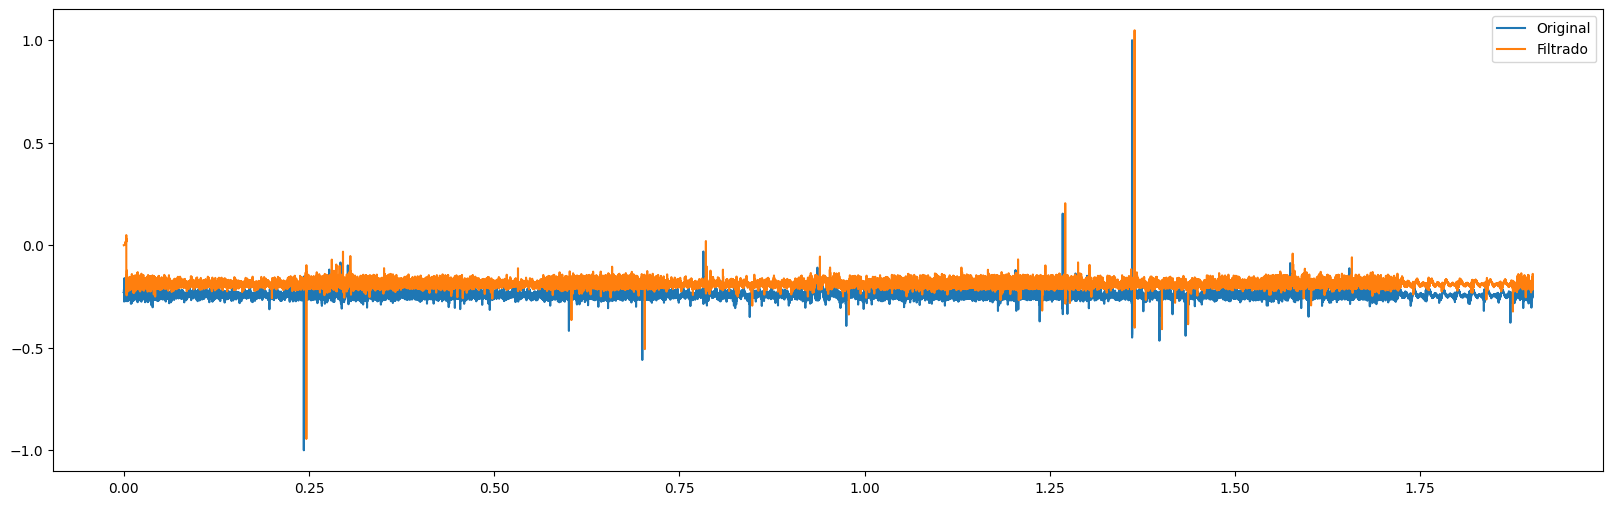

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(t, audio_m[100], label='Original')
plt.plot(t, audio_filt[100], label='Filtrado')
plt.legend()
plt.show()

In [ ]:
f, psd_ones = psd_matrix(audio_ones, fs,  'blackmanharris')
f, psd_zeros = psd_matrix(audio_zeros, fs,  'blackmanharris')

In [ ]:
print('psd_emisora=', psd_ones.shape)
print('psd_ruido=', psd_zeros.shape)

psd_emisora= (544, 83886)
psd_ruido= (661, 83886)


<ipython-input-12-e44406ba9ed7>:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,np.max(f)])


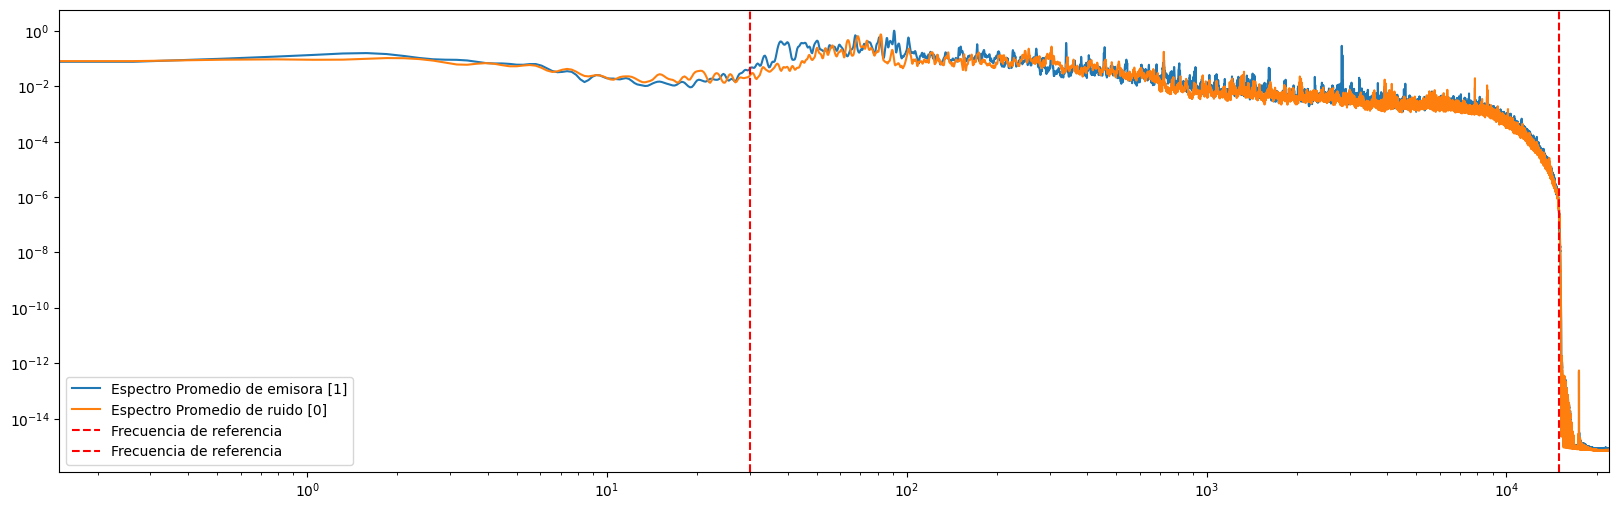

In [ ]:
psd_ones_mean = np.mean(psd_ones, axis=0)
psd_zeros_mean = np.mean(psd_zeros, axis=0)

psd_ones_max = np.max(psd_ones_mean)
psd_zeros_max = np.max(psd_zeros_mean)

psd_ones_mean_normalized = psd_ones_mean / psd_ones_max
psd_zeros_mean_normalized = psd_zeros_mean / psd_ones_max



plt.figure(figsize=(20,6))
plt.loglog(f, psd_ones_mean_normalized, label='Espectro Promedio de emisora [1]')
plt.loglog(f, psd_zeros_mean_normalized, label='Espectro Promedio de ruido [0]')
plt.axvline(x=30, color='red', linestyle='--', label='Frecuencia de referencia')
plt.axvline(x=15000, color='red', linestyle='--', label='Frecuencia de referencia')
plt.xlim([0,np.max(f)])
plt.legend()
plt.show()

In [ ]:
print(np.max(psd_ones_mean_normalized))

1.0


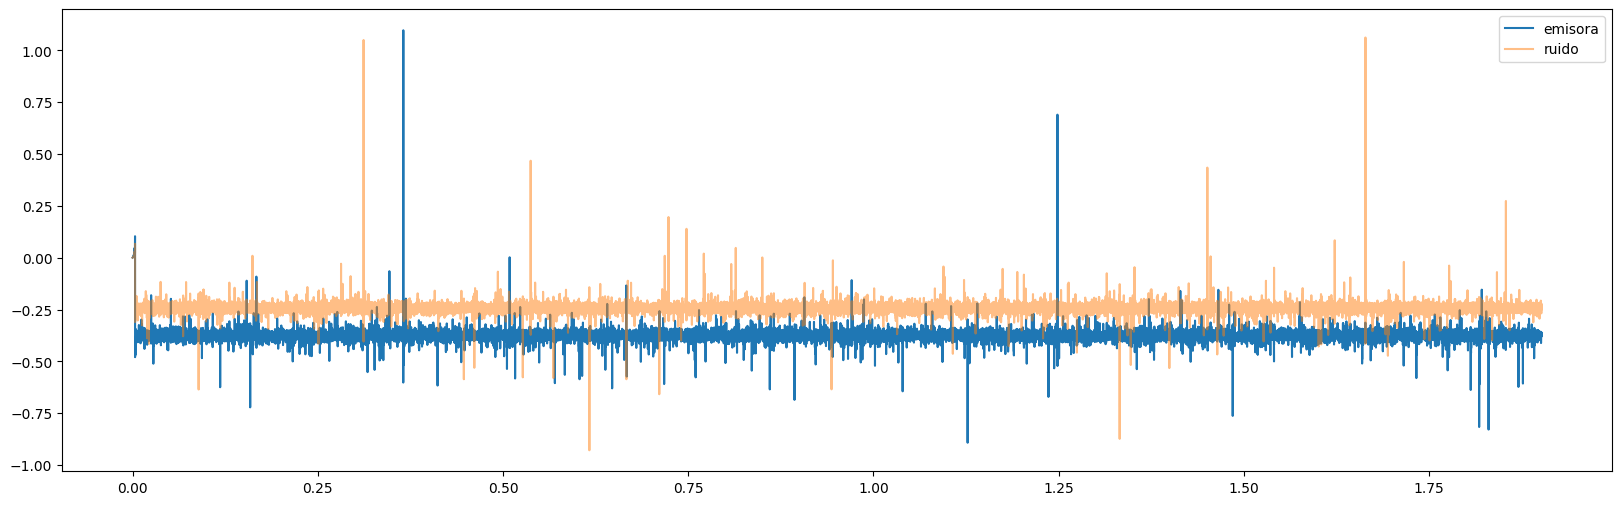

In [ ]:
plt.figure(figsize=(20,6))

plt.plot(t, audio_ones[200], label='emisora')
plt.plot(t, audio_zeros[200], label='ruido', alpha=.5)
plt.legend()
plt.show()


In [ ]:
snrdB = snr(audio_ones, audio_zeros)
print(f'snr de las señales respecto al ruidoo es ={snrdB}dB')

snr de las señales respecto al ruidoo es =3.50107373183069dB
